# Loading the Data

The data is stored as a CSV file the data is loaded as a pandas dataframe. Initially, Exploratory Data Analysis is carried out on the dataset to get the basic information about the dataset

In [1]:
import pandas as pd

# Load the AAPL stock data
data_file = 'AAPL.csv'
data = pd.read_csv(data_file)

# Display the first few rows of the dataset
print(data.head())


         Date      Open      High       Low     Close  Adj Close     Volume
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.099058  469033600
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093890  175884800
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086998  105728000
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089152   86441600
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091737   73449600


## Basic EDA

Head of the data, data type of each column and basic statistics are viewed

In [2]:
# Display the first few rows
print(data.head())

# Check the data types of each column
print(data.dtypes)

# Get basic statistics
print(data.describe())


         Date      Open      High       Low     Close  Adj Close     Volume
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.099058  469033600
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093890  175884800
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086998  105728000
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089152   86441600
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091737   73449600
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
               Open          High           Low         Close     Adj Close  \
count  10979.000000  10979.000000  10979.000000  10979.000000  10979.000000   
mean      21.946871     22.184118     21.720639     21.961269     21.166518   
std       45.255989     45.745412     44.805325     45.294214     44.857211   
min        0.049665      0.049665      0.049107      0.049107      

## Handling Timestamps

Date column is converted into datetime for ease of access

In [3]:
# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set Date as the index
data.set_index('Date', inplace=True)

print(data.head())


                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
1980-12-12  0.128348  0.128906  0.128348  0.128348   0.099058  469033600
1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093890  175884800
1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086998  105728000
1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089152   86441600
1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091737   73449600


# Data Visualisation

### 1.Plot of Closing price over time

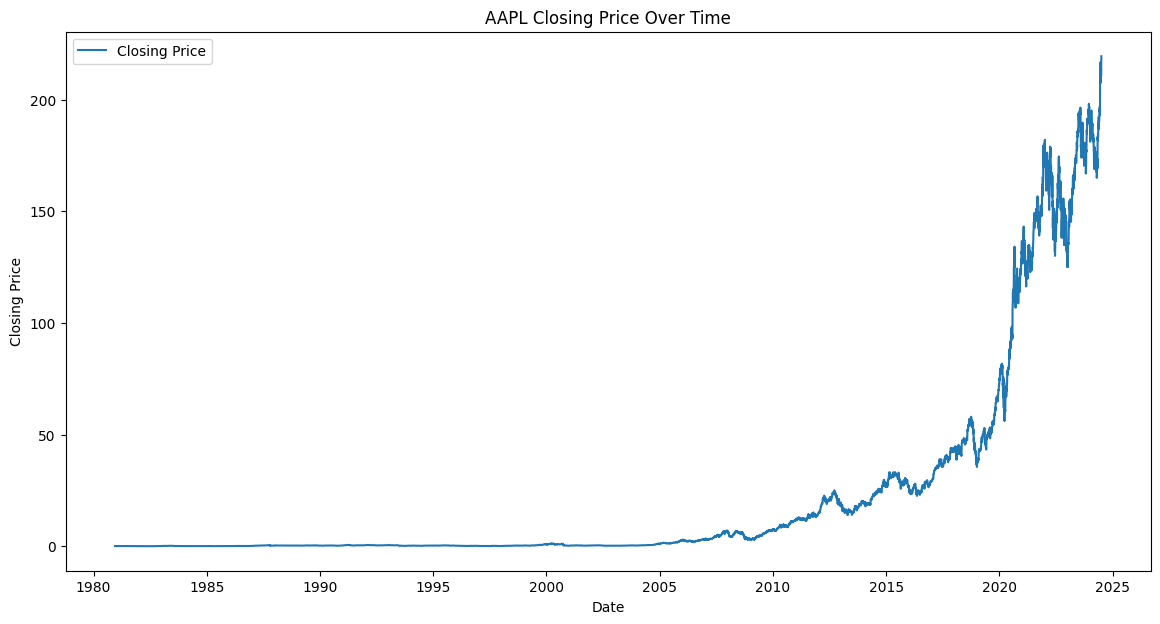

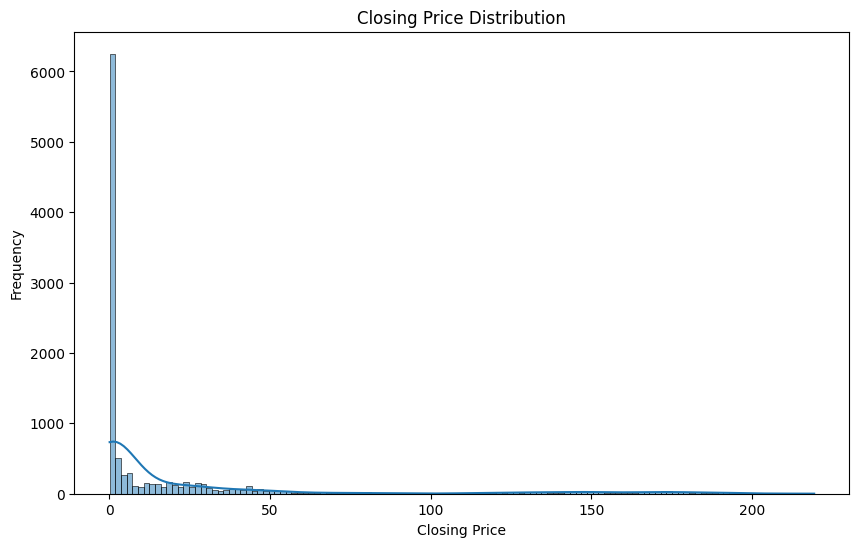

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot closing price over time
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Closing Price')
plt.title('AAPL Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Plot distribution of closing prices
plt.figure(figsize=(10, 6))
sns.histplot(data['Close'], kde=True)
plt.title('Closing Price Distribution')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()


# Data Preprocessing
**Feature Selection:**

Use the closing price as the target variable.

**Normalization:**

Normalize the features for better model performance.

**Sequence Generation:**

Generate sequences for the models.

In [6]:
import numpy as np

# Select features and target
features = data[['Open', 'High', 'Low', 'Close', 'Volume']]
target = data['Close']

# Normalize the features
features = (features - features.mean()) / features.std()

# Create sequences
def create_sequences(features, target, seq_length):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features.iloc[i:i+seq_length].values)
        y.append(target.iloc[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60  # Use the past 60 days to predict the next day
X, y = create_sequences(features, target, seq_length)

# Split into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# Model Evaluation

Implementation and training of RNN, LSTM, GRU, Seq2Seq, and MANN models.

**1. RNN Model**

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 20

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert data to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
test_dataset = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).float())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for features, target in train_loader:
        features, target = features.to(device), target.to(device)
        
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, target)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


c:\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20], Loss: 42.0683
Epoch [2/20], Loss: 74.5242
Epoch [3/20], Loss: 24.3936
Epoch [4/20], Loss: 62.9252
Epoch [5/20], Loss: 13.9921
Epoch [6/20], Loss: 13.8577
Epoch [7/20], Loss: 25.7753
Epoch [8/20], Loss: 51.3232
Epoch [9/20], Loss: 36.4418
Epoch [10/20], Loss: 17.4410
Epoch [11/20], Loss: 23.1302
Epoch [12/20], Loss: 36.4273
Epoch [13/20], Loss: 33.4411
Epoch [14/20], Loss: 22.9854
Epoch [15/20], Loss: 56.0136
Epoch [16/20], Loss: 39.8040
Epoch [17/20], Loss: 98.6139
Epoch [18/20], Loss: 22.2371
Epoch [19/20], Loss: 59.7737
Epoch [20/20], Loss: 62.7707


In [13]:
import torch
# Device configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


## Model Evaluation
Metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE). Additionally, we can visualize the predicted vs. actual values.

Mean Absolute Error (MAE): 94.8106
Mean Squared Error (MSE): 12873.5469
Root Mean Squared Error (RMSE): 113.4617


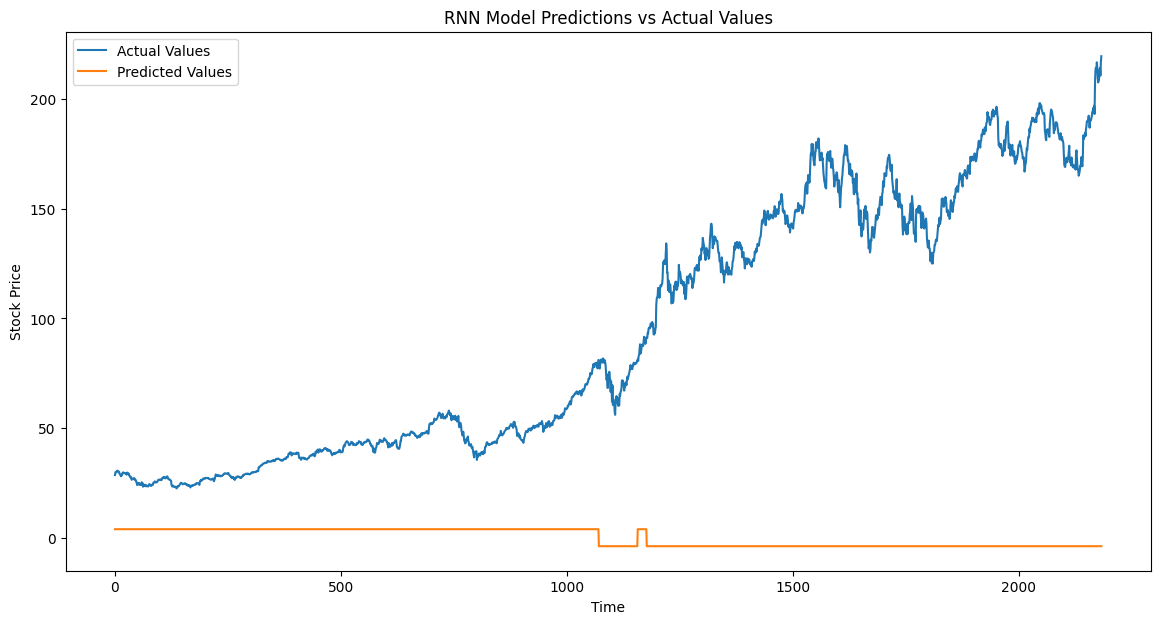

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Evaluation
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for features, target in test_loader:
        features, target = features.to(device), target.to(device)
        outputs = model(features)
        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(target.cpu().numpy())

# Convert predictions and targets to numpy arrays
y_pred = np.array(y_pred).flatten()
y_true = np.array(y_true).flatten()

# Calculate evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_true, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('RNN Model Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Additional Evaluation

Categorize the predictions into -1 (down), 0 (no change), 1 (up) and correspondingly calculating the accuracy, precision, recall and f1 score

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert to categorical values: -1 (down), 0 (no change), 1 (up)
def categorize(y):
    categories = np.zeros_like(y)
    categories[1:] = np.where(np.diff(y) > 0, 1, -1)
    return categories

y_pred_cat = categorize(y_pred)
y_true_cat = categorize(y_true)

# Calculate classification metrics
accuracy = accuracy_score(y_true_cat, y_pred_cat)
precision = precision_score(y_true_cat, y_pred_cat, average='macro')
recall = recall_score(y_true_cat, y_pred_cat, average='macro')
f1 = f1_score(y_true_cat, y_pred_cat, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.5078
Precision: 0.6751
Recall: 0.6749
F1 Score: 0.6709
